<a href="https://colab.research.google.com/github/cohock13/infection_model/blob/master/Covidsim_AIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

最初の実行時に，<b>「ランタイム」 -> 「すべてのセルを実行」</b>してください．<br><br>
ちなみにですが，多分セルを実行するとアカウントの情報などの選択が出てくると思います．名前と実行日時くらいしかこちらからは確認できませんが，どうしても嫌という方は，「ファイル」 -> 「ドライブにコピーを保存」して，自分のドライブからアクセスすればこの辺に同意せず自分のドライブで作業ができます．

In [ ]:
import matplotlib.pyplot as plt
from random import random,randint
import numpy as np
from collections import defaultdict

シミュレータ部分です．この辺は用事がない限りいじくらないでください．<br>
もしバグを見つけて，訂正可能な場合はデバッグをしていただいて構いません(むしろありがたいです)．その場合はコード中のコメントやColabのテキストなどで訂正した人の名前，時間を記録していただけますと幸いです．

In [ ]:
import matplotlib.pyplot as plt
from random import random,randint
import numpy as np
from collections import defaultdict

vector = np.array([(0,1),(0,-1),(1,1),(1,-1),(1,0),(-1,1),(-1,-1),(-1,0)])

class Cell(object):

  def __init__(self,leq60):
    if leq60:
      self.gamma = gamma_leq60
      self.lambda_ = lambda_leq60
      self.t = t_leq60
      self.a = a_leq60
    else:
      self.gamma = gamma_geq60
      self.lambda_ = lambda_geq60
      self.t = t_geq60
      self.a = a_geq60
    self.state = "Infected" if random() < alpha else "Suspicious"
    self.pos = [int(random()*BOUNDARY),int(random()*BOUNDARY)]
    self.time = 0

  def move(self):
    if (self.state == "Infected" and random() < self.a*self.lambda_) or (self.state in ["Suspicious","Recovered"] and random() < self.lambda_):
      v = vector[randint(0,7)] 
      if not OPEN_BOUNDARY:
        if 0 <= self.pos[0] + v[0] <= BOUNDARY and 0 <= self.pos[1] + v[1] <= BOUNDARY:
          self.pos[0],self.pos[1] = self.pos[0]+v[0],self.pos[1]+v[1]
      else:
        self.pos[0],self.pos[1] = self.pos[0]+v[0],self.pos[1]+v[1]

  def infect(self):
    if random() < alpha and self.state == "Suspicious":
      self.state = "Infected"

  def update(self,infected_num):
    if self.state == "Infected":
      if infected_num >= N:
        p = random()
        if p < beta_dash:
          self.state = "Recovering"
        elif p > 1 - self.gamma:
          self.state = "Dead"
      else:
        if random() < beta:
          self.state = "Recovering"
    elif self.state == "Recovering":
      self.time += 1
      if self.time >= self.t:
        self.state = "Suspicious"
        self.time = 0

class Simulator:
  def __init__(self):
    self.cells = [Cell(True) for _ in range(N_leq60)] + [Cell(False) for _ in range(N_geq60)]
    self.state_leq60 = np.array([])
    self.state_geq60 = np.array([])
  
  def simulate(self):

    for _ in range(TIME):
      pos = defaultdict(list)
      infected_num = sum([cell.state == "Infected" for cell in self.cells])
      num_leq60 = defaultdict(list)
      num_geq60 = defaultdict(list)

      for i in range(len(self.cells)):
        cell = self.cells[i]
        pos[tuple(cell.pos)].append(i)
        if cell.state == "Infected":
          pos[tuple(cell.pos)].append(float("inf"))
          
      for p in pos.values():
        if float("inf") in p:
          for i in p:
            try:
              self.cells[i].infect()
            except:
              pass

      for s in ["Suspicious","Infected","Recovering","Dead"]:
        num_leq60[s] = 0
        num_geq60[s] = 0
      
      for cell in self.cells:
        cell.update(infected_num)
        cell.move()
      
      for cell in self.cells[:N_leq60]:
        num_leq60[cell.state] += 1
      
      for cell in self.cells[N_leq60:]:
        num_geq60[cell.state] += 1
      
      self.state_leq60 = np.append(self.state_leq60,np.array(list(num_leq60.values())))
      self.state_geq60 = np.append(self.state_geq60,np.array(list(num_geq60.values())))
      
  
  def show(self):
    t = np.linspace(1,TIME,TIME)

    plt.rcParams["font.size"] = 20

    self.state_leq60 = self.state_leq60.reshape((TIME,4))
    plt.figure(figsize=(15,8))
    plt.fill_between(t,100,label="Suspicious",color="palegreen")
    plt.fill_between(t,100/N_leq60*(self.state_leq60[:,3]+self.state_leq60[:,1]+self.state_leq60[:,2]),label="Recovering",color="skyblue")
    plt.fill_between(t,100/N_leq60*(self.state_leq60[:,3]+self.state_leq60[:,1]),label="Infected",color="tomato")
    plt.fill_between(t,100/N_leq60*self.state_leq60[:,3],label="Dead",color="gray")
    plt.title("Aged <= 60")
    plt.xlabel("time")
    plt.ylabel("rate[%]")
    plt.legend()
    plt.show()

    self.state_geq60 = self.state_geq60.reshape((TIME,4))
    plt.figure(figsize=(15,8))
    plt.fill_between(t,100,label="Suspicious",color="palegreen")
    plt.fill_between(t,100/N_geq60*(self.state_geq60[:,3]+self.state_geq60[:,1]+self.state_geq60[:,2]),label="Recovering",color="skyblue")
    plt.fill_between(t,100/N_geq60*(self.state_geq60[:,3]+self.state_geq60[:,1]),label="Infected",color="tomato")
    plt.fill_between(t,100/N_geq60*self.state_geq60[:,3],label="Dead",color="gray")
    plt.title("Aged >= 60")
    plt.xlabel("time")
    plt.ylabel("rate[%]")
    plt.legend()
    plt.show()

    

  


パラメータ部分です．この辺をいじくってください．<br><br>
<b>TIME</b>はシミュレーションの時間，<b>N_hoge</b>は60歳以上，以下の人数，<b>BOUNDARY</b>が境界(一辺BOUNDARYの正方形を動き回ります．OPEN_BOUNDARYにチェックを入れると境界なしモデルになります)，<b>hoge_leq60</b>は60歳 以下のパラメータ，<b>hoge_geq60</b>は60歳以上のパラメータです．<br>
また，元のモデルにあった移動確率λについてですが，こちらは「方向関係なく移動する確率」として実装したため，0から1の値を入れてください．

In [ ]:
#@title Initial Condition
TIME = 1000#@param {type:"number"}
OPEN_BOUNDARY = False#@param {type:"boolean"}
BOUNDARY = 10#@param {type:"number"}
N_leq60 = 200#@param {type:"number"}
N_geq60 = 200#@param {type:"number"}
N = 150#@param {type:"number"}
alpha= 0.03#@param {type:"number"}
beta = 0.02#@param {type:"number"}
beta_dash = 0.01#@param {type:"number"}
gamma_leq60 = 0.001#@param {type:"number"}
gamma_geq60 = 0.005#@param {type:"number"}
t_leq60 = 30#@param {type:"number"}
t_geq60 = 50#@param {type:"number"}
lambda_leq60 = 0.1#@param {type:"number"}
lambda_geq60 = 0.05#@param {type:"number"}
a_leq60 = 0.5#@param {type:"number"}
a_geq60 = 0.3#@param {type:"number"}

プロット部分です．パラメータを変えたらここのボタンを押してください．

(自分で試した分ですが，確率モデルなのでやっぱり結果が振れやすいです．セルが被らないと感染が発生しないので，感染爆発はBOUNDARYが相当小さい場合でないと発生しないようです．)

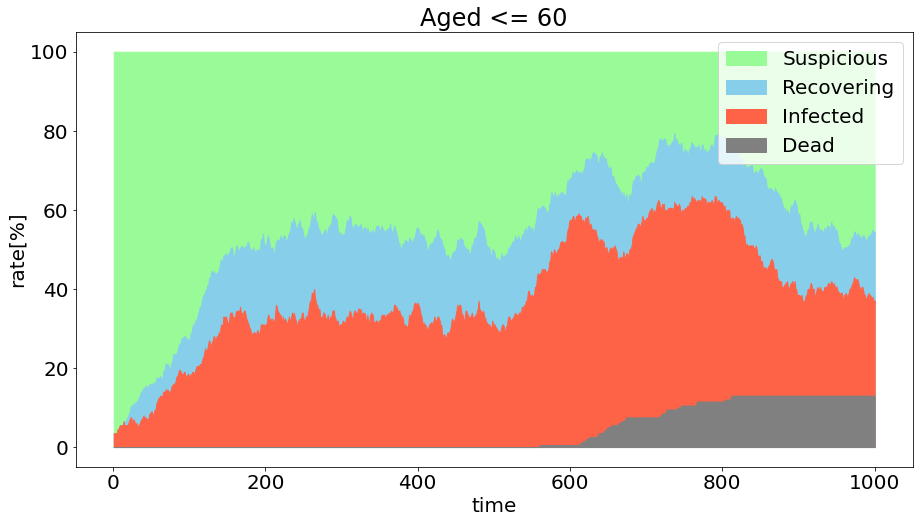

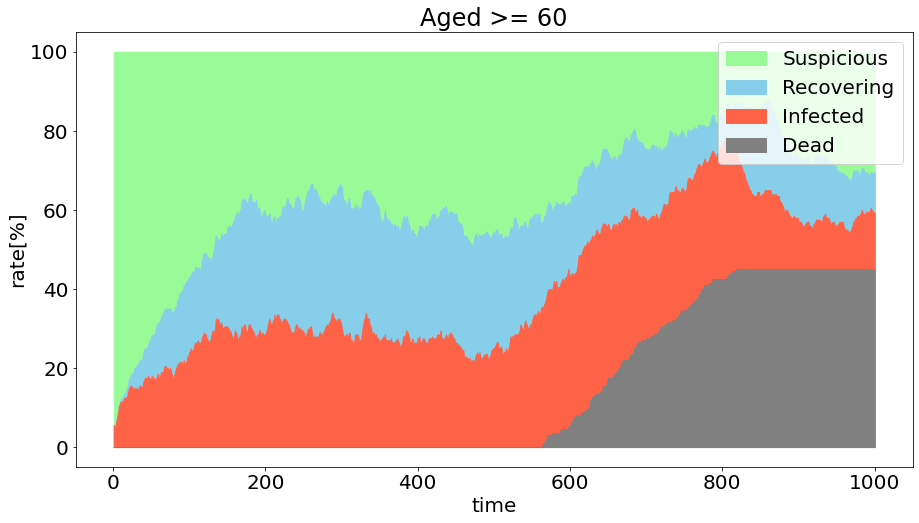

In [ ]:
sim = Simulator()
sim.simulate()
sim.show()